## BBDC 2023

Welcome to the Bremen Big Data Challenge 2023!

In this year’s task, measurement data from water samples shall be processed. The measurements were carried out by the Alfred-Wegener-Institut near Helgoland (North Sea) and recorded over a period of 54 years ``(01.01.1962 - 31.12.2015)``.

The measurement data is structured as a table. For each measurement there is one entry with 8 values given.
Since this is real world measurement data, some data points may be missing. Those are marked as empty entries or with "NA".
Also, entries could be noted with an additional "?" to indicate that the recorded value is uncertain. The data is entered in English format (decimal places/decimal separators are indicated by a dot "." and thousands separators by a comma ",").

The development file contains the pure measurement data including missing entries and "?" notes over a period from ``01.01.1962 - 31.12.2010``.

Based on this data, a forecasting model shall be developed to predict values for the evaluation periods ``01.01.2004 - 31.12.2004`` and ``01.01.2011 - 31.12.2013``.

The exact days for which predictions are to be made are specified in the file "``bbdc_2023_AWI_data_evaluate_skeleton.csv``" ``("Datum", "Uhrzeit")``. For each specified day, the values "SECCI", "Temperatur", "Salinität", "NO2", "NO3", and "NOx" have to be predicted.

Note: Missing values or "NA" do not have to be predicted. Only valid values, indicated by the days given in the "bbdc_2023_AWI_data_evaluate_skeleton.csv" file, must be predicted.

Note: The data says "SECCI", but means "SECCHI".

For submission, the filled ``"bbdc_2023_AWI_data_evaluate_skeleton.csv"`` file must be submitted via the Submission System.

The evaluation metric is the Root Mean Squared Error (``RMSE``). Due to the variable scaling in the raw format, the input and reference data will be Z-normalized and the RMSE will be calculated on them.

Good luck and have fun!

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

## Reading the data

We start with reading the data available for trainign the model. Be aware that the data is separated by ``semicolons``.

In [ ]:
# Load the dataset
df = pd.read_csv('bbdc_2023_AWI_data_develop_student.csv', delimiter=';')

In [ ]:
df.head()

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,NaN,NaN,Meter,°C,NaN,µmol/l,µmol/l,µmol/l
1,01.01.1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02.01.1962,9:00,NaN,4.6,NaN,NaN,NaN,NaN
3,03.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN
4,04.01.1962,9:00,NaN,4.3,NaN,NaN,NaN,NaN


In [ ]:
df.isnull().sum()

Datum             1
Uhrzeit        6011
SECCI          8040
Temperatur     6109
Salinität      6300
NO2            7377
NO3            7446
NOx           16077
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17532 entries, 0 to 17531
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Datum       17531 non-null  object 
 1   Uhrzeit     11521 non-null  object 
 2   SECCI       9492 non-null   object 
 3   Temperatur  11423 non-null  object 
 4   Salinität   11232 non-null  float64
 5   NO2         10155 non-null  object 
 6   NO3         10086 non-null  object 
 7   NOx         1455 non-null   object 
dtypes: float64(1), object(7)
memory usage: 1.1+ MB


In [ ]:
df = df.drop(index=0)

In [ ]:
# Parse datetime strings using format string '%Y-%m-%d %H:%M'
df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y')
df['DateTime'] = pd.to_datetime(df['Datum'].astype(str), format='%Y-%m-%d')
df['SECCI'] = pd.to_numeric(df['SECCI'], errors='coerce')
df['Temperatur'] = pd.to_numeric(df['Temperatur'], errors='coerce')
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')
df['NO3'] = pd.to_numeric(df['NO3'], errors='coerce')
df['NOx'] = pd.to_numeric(df['NOx'], errors='coerce')

In [ ]:
df.head()

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,DateTime
1,1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962-01-01
2,1962-01-02,9:00,NaN,4.6,NaN,NaN,NaN,NaN,1962-01-02
3,1962-01-03,9:00,NaN,5.1,NaN,NaN,NaN,NaN,1962-01-03
4,1962-01-04,9:00,NaN,4.3,NaN,NaN,NaN,NaN,1962-01-04
5,1962-01-05,9:00,NaN,5.1,NaN,NaN,NaN,NaN,1962-01-05


In [ ]:
df.drop([ 'Datum', 'Uhrzeit'], axis=1, inplace=True)

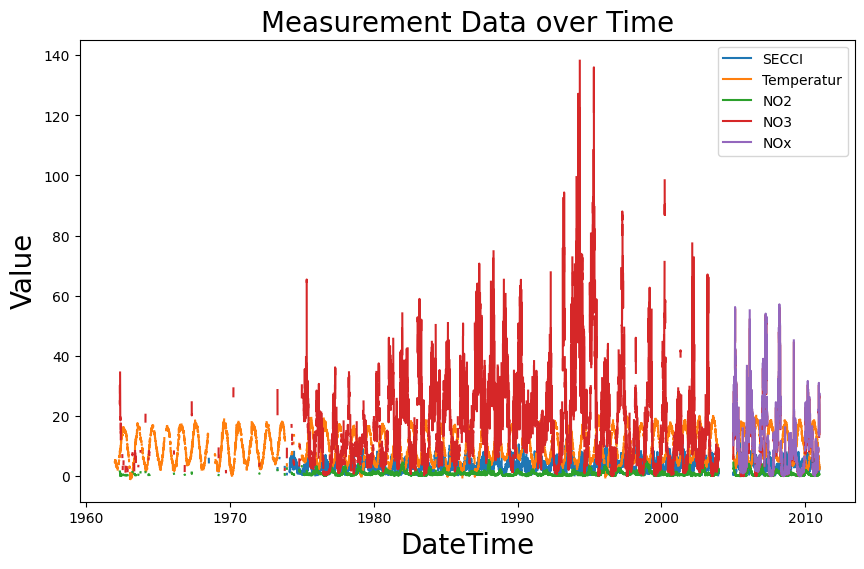

In [ ]:
# plot columns of interest directly
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['DateTime'], df['SECCI'], label='SECCI')
ax.plot(df['DateTime'], df['Temperatur'], label='Temperatur')
ax.plot(df['DateTime'], df['NO2'], label='NO2')
ax.plot(df['DateTime'], df['NO3'], label='NO3')
ax.plot(df['DateTime'], df['NOx'], label='NOx')
ax.legend()
ax.set_xlabel('DateTime', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.set_title('Measurement Data over Time', fontsize=20)
plt.show()

In [ ]:
min_date = df.loc[df['NOx'].notna(), 'DateTime'].min()
print(min_date)

2005-01-03 00:00:00


## correlations

In [ ]:
# select numerical columns
numerical_cols = df.select_dtypes(include=['float', "int"]).columns
# compute the pairwise correlations
df_corr = df[numerical_cols].corr().round(2)

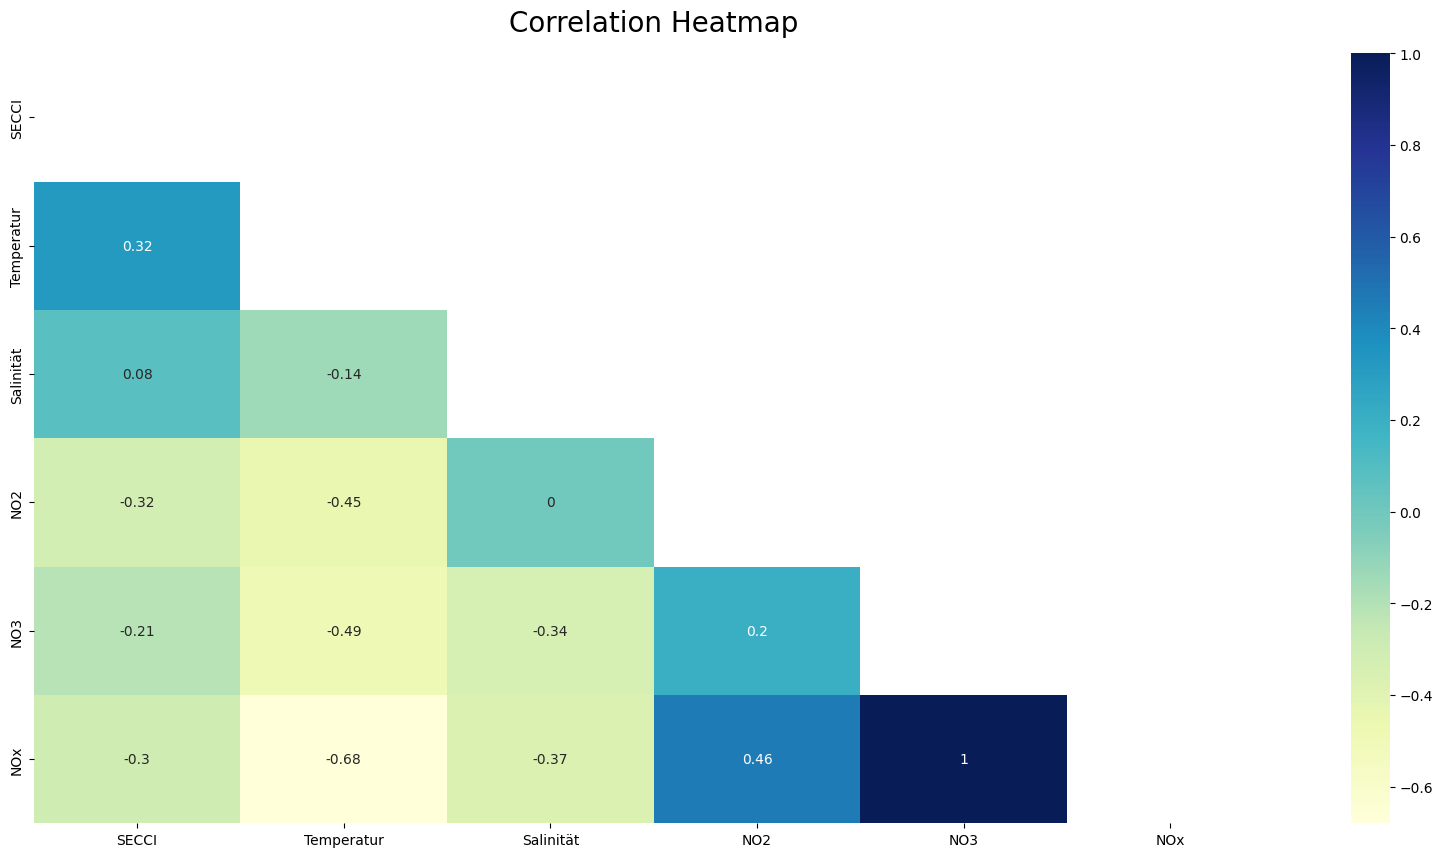

In [ ]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))
#Correlation using heatmap
plt.figure(figsize = (20, 10))
heatmap = sns.heatmap(df_corr, mask=mask, annot=True, cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16);
plt.show()

In [ ]:
df.drop([ 'NOx'], axis=1, inplace=True)

In [ ]:
df.isnull().sum()

SECCI         8040
Temperatur    6109
Salinität     6299
NO2           7377
NO3           7446
DateTime         0
dtype: int64

In [ ]:
# Set the date column as the index
df = df.set_index('DateTime')

### k-NN imputation

In [ ]:
from sklearn.impute import KNNImputer

# Identify the missing values
missing_values = df.isnull()

# Apply k-NN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(df)

# Convert the imputed array back to a DataFrame
df_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df.index)

# Replace the missing values in df with the imputed values
df = df_imputed

In [ ]:
df.head()

,SECCI,Temperatur,Salinität,NO2,NO3
DateTime,,,,,
1962-01-01,3.538025,10.137813,32.066982,0.811982,15.32045
1962-01-02,3.420000,4.600000,32.669000,2.658000,18.67600
1962-01-03,3.040000,5.100000,30.900600,1.304000,23.63800
1962-01-04,2.820000,4.300000,33.151800,1.660000,17.50600
1962-01-05,3.040000,5.100000,30.900600,1.304000,23.63800


### outliers

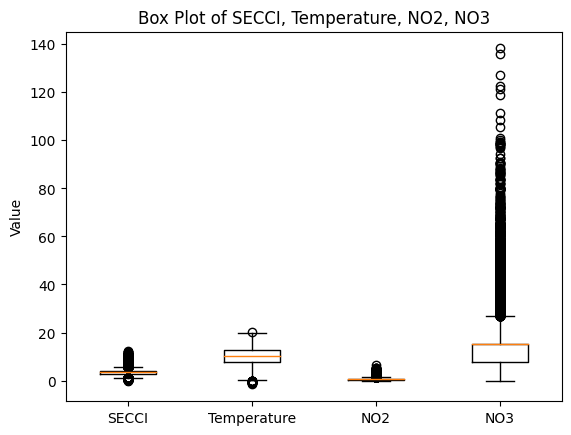

In [ ]:
plt.boxplot([df['SECCI'], df['Temperatur'], df['NO2'], df['NO3']])
plt.title('Box Plot of SECCI, Temperature, NO2, NO3')
plt.xticks([1, 2, 3, 4], ['SECCI', 'Temperature', 'NO2', 'NO3'])
plt.ylabel('Value')
plt.show()

In [ ]:
# Calculate quartiles and IQR for each feature
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper limits for each feature
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Replace outliers with lower/upper limit for each feature
for col in df.columns:
    df[col] = df[col].apply(lambda x: lower_limit[col] if x < lower_limit[col] else (upper_limit[col] if x > upper_limit[col] else x))

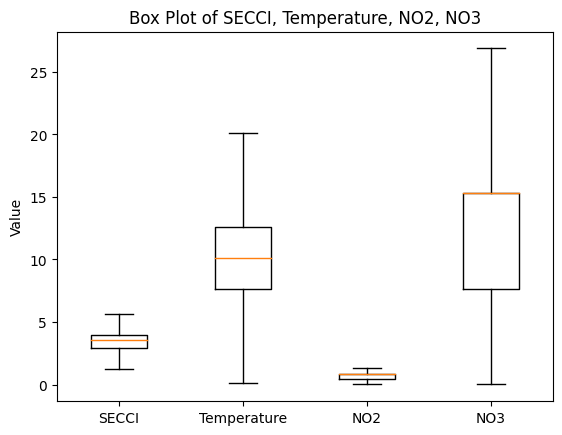

In [ ]:
plt.boxplot([df['SECCI'], df['Temperatur'], df['NO2'], df['NO3']])
plt.title('Box Plot of SECCI, Temperature, NO2, NO3')
plt.xticks([1, 2, 3, 4], ['SECCI', 'Temperature', 'NO2', 'NO3'])
plt.ylabel('Value')
plt.show()

## Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for each variable
for col in df.columns:
    result = adfuller(df[col].dropna())
    print(f'{col} ADF Statistic: {result[0]:.3f}')
    print(f'{col} p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    print('\n')

SECCI ADF Statistic: -10.800
SECCI p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567


Temperatur ADF Statistic: -13.419
Temperatur p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567


Salinität ADF Statistic: -10.778
Salinität p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567


NO2 ADF Statistic: -10.309
NO2 p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567


NO3 ADF Statistic: -9.150
NO3 p-value: 0.000
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567




This output is the result of running an Augmented Dickey-Fuller (ADF) test on the Temperatur time series data. The ADF test is used to test for the presence of a unit root in a time series, which indicates non-stationarity. A non-stationary time series has a statistical properties that change over time, such as a changing mean, variance, or autocorrelation.

The output provides the ADF statistic, which is a test statistic for the ADF test. The more negative the ADF statistic, the stronger the evidence against the presence of a unit root and the more likely the time series is stationary. In this case, the ADF statistic is -22.622, which is highly negative and indicates strong evidence against the presence of a unit root and for the stationarity of the time series.

The output also provides the p-value for the ADF test, which is the probability of observing a test statistic as extreme as the one computed, assuming the null hypothesis that there is a unit root in the time series. A p-value less than the significance level (typically 0.05 or 0.01) provides evidence against the null hypothesis and in favor of the alternative hypothesis that the time series is stationary. In this case, the p-value is 0.000, which is less than any typical significance level and provides strong evidence against the null hypothesis of a unit root.

Finally, the output provides critical values for the ADF test at different levels of significance (1%, 5%, and 10%). These critical values can be used to compare the ADF statistic to determine if it is significant at a particular level. If the ADF statistic is more negative than the critical value, then the null hypothesis can be rejected and the time series can be considered stationary at that level of significance. In this case, the ADF statistic is more negative than all of the critical values, providing further evidence for the stationarity of the Temperatur time series.

## SARIMAX
https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

What is SARIMAX?
Among the most ‘seasoned’ techniques for time series forecast, there is ARIMA, which is the acronym of Auto Regressive Integrated Moving Average. Even though ARIMA has shown evidence for working fairly, it has the major pitfall of not being able to handle seasonality.

SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

Accordingly, SARIMAX represents an ‘upgrade’ to the seasoned ARIMA model. In a nutshell, such an upgrade is performed for adding seasonality and exogenous factors.

Herein, the theory behind the model is not duly described. The reader is encouraged to read and understand more about the math behind both ARIMA and SARIMAX on his own as it will heavily facilitate the understanding of the procedure described as follows.

In order to fit a SARIMAX, we need to define values for parameters p, d and q, where:

- p is the number of autoregressive terms
- d is the number of non-seasonal differences needed for stationarity
- q is the number of lagged forecast errors in the prediction equation
The above three parameters do not take into account seasonality. A separate estimate is performed to evaluate seasonal p, d, q.

Fitting a SARIMAX involves an iterative search of an ‘optimal combo’ of non-seasonal p, d, q along with seasonal p, d, q. In our case, we take the three following steps sequentially:

- Define p, d and q parameters to take any value between 0 and 2
- Generate all different combinations of p, q and q triplets
- Define seasonal p, d and q parameters in function of p, d, q with a maximum value of 12.
- Generate all different combinations of seasonal p, q and q triplets

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x800 with 0 Axes>

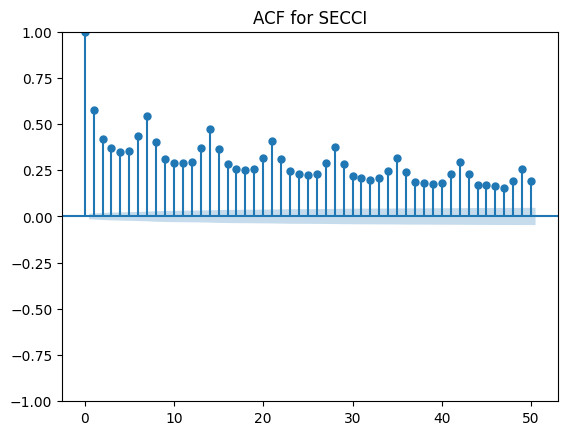

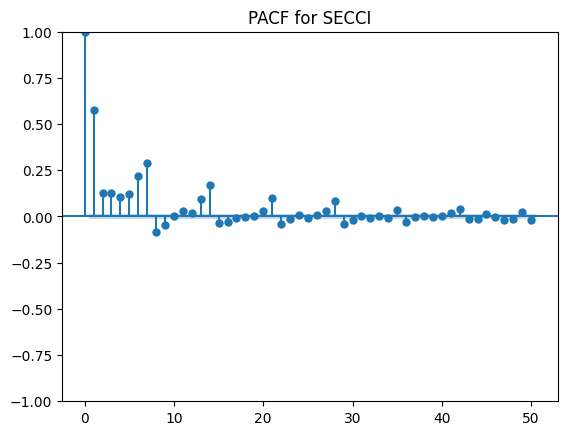

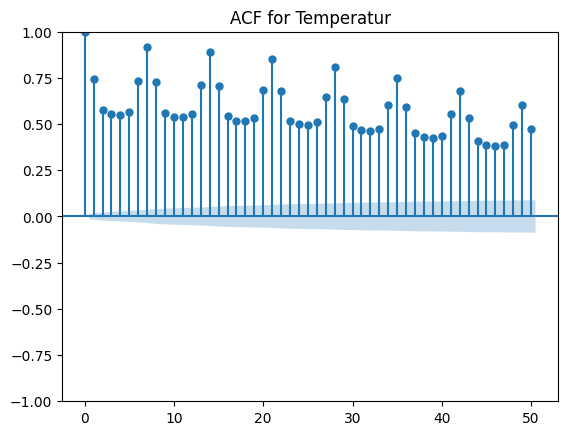

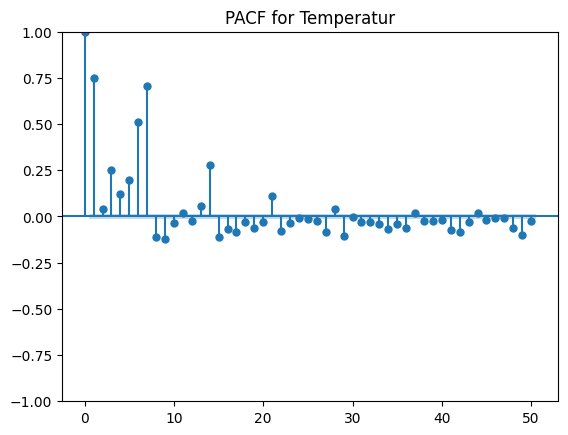

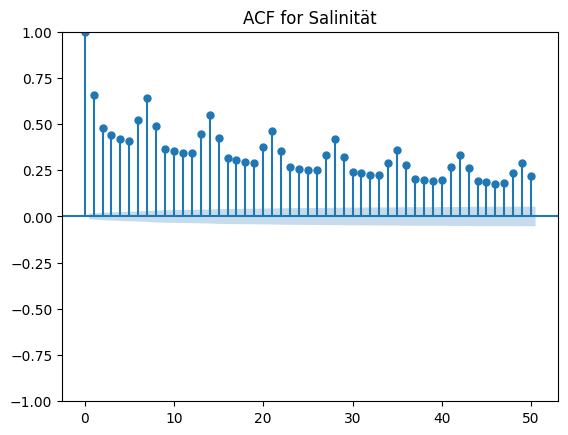

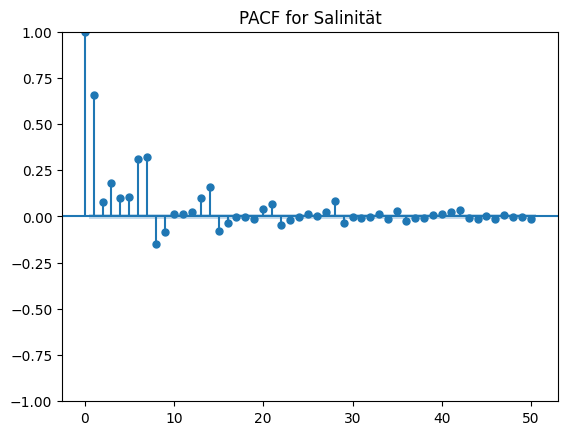

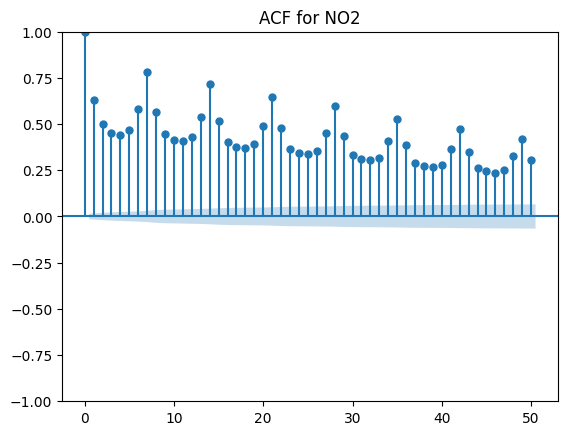

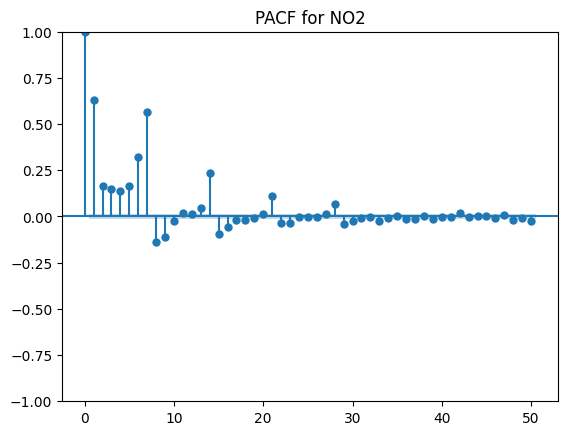

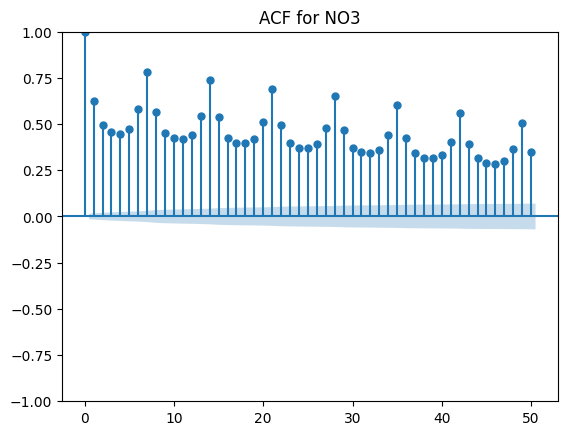

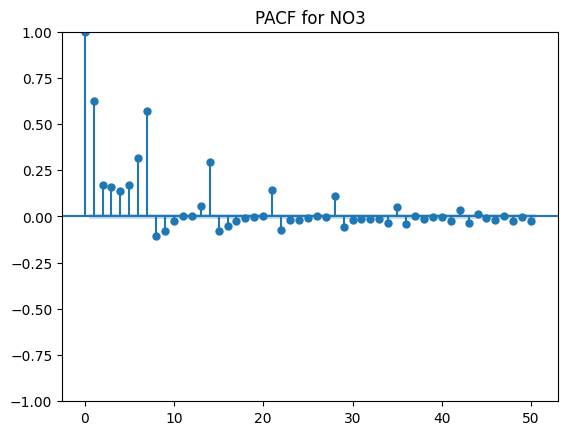

In [ ]:
# Plot ACF and PACF of each column
plt.figure(figsize=(12, 8))
for column in df.columns:
    plot_acf(df[column], lags=50, title=f'ACF for {column}')
    plot_pacf(df[column], lags=50, title=f'PACF for {column}')
plt.show()

In [ ]:
# Split data into train and test sets
train_data = df[:-1000]
test_data = df[-1000:]

In [ ]:
# Fit SARIMA model on training data for each feature
# preds = {}
# for col in train_data.columns:
#     model = SARIMAX(train_data[col], order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
#     results = model.fit()
#     preds[col] = results.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
#     preds[col].index = test_data.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [ ]:
# Convert predictions to a dataframe
pred_df = pd.DataFrame.from_dict(preds)

In [ ]:
pred_df

,SECCI,Temperatur,Salinität,NO2,NO3
DateTime,,,,,
2008-04-06,3.045475,8.468216,31.832220,0.788489,20.657101
2008-04-07,2.788474,6.722486,31.634447,0.782586,23.093000
2008-04-08,2.848902,5.968222,31.543682,0.784762,22.033069
2008-04-09,2.774459,6.374606,31.516384,0.778882,23.050999
2008-04-10,2.840234,7.133403,31.546629,0.779241,22.279509
...,...,...,...,...,...
2010-12-27,2.760496,7.268028,31.549362,0.766697,22.868586
2010-12-28,2.756173,7.265418,31.541338,0.766323,22.795206
2010-12-29,2.752199,7.282288,31.550675,0.765996,22.915643


In [ ]:
# Evaluate predictions using RMSE
from sklearn.metrics import mean_squared_error
rmse = {}
for col in train_data.columns:
    rmse[col] = np.sqrt(mean_squared_error(test_data[col], pred_df[col]))
print("RMSE:", rmse)

RMSE: {'SECCI': 1.4957776641944849, 'Temperatur': 5.474429555502481, 'Salinität': 1.0890513574051965, 'NO2': 0.42971962273950315, 'NO3': 14.861931487896804}


#### RMSE over all variables.

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for each variable
rmse = {}
for col in test_data.columns:
    rmse[col] = np.sqrt(mean_squared_error(test_data[col], pred_df[col]))

# Calculate mean RMSE over all variables
mean_rmse = sum(rmse.values()) / len(rmse)
print(f"Mean RMSE: {mean_rmse:.4f}")

Mean RMSE: 4.6702


## LSTM model

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Define the input and output sequences
window_size = 60
X = []
Y = []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    Y.append(scaled_data[i, :])
X = np.array(X)
Y = np.array(Y)

# Split the dataset into training, validation, and testing sets
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
X_train = X[:train_size, :, :]
Y_train = Y[:train_size, :]
X_val = X[train_size:train_size+val_size, :, :]
Y_val = Y[train_size:train_size+val_size, :]
X_test = X[train_size+val_size:, :, :]
Y_test = Y[train_size+val_size:, :]

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(Y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the LSTM model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)

# Make predictions using the LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform(Y_test)


Epoch 1/50
328/328 [==============================] - 41s 119ms/step - loss: 0.0404 - val_loss: 0.0381
Epoch 2/50
328/328 [==============================] - 37s 114ms/step - loss: 0.0345 - val_loss: 0.0383
Epoch 3/50
328/328 [==============================] - 31s 95ms/step - loss: 0.0337 - val_loss: 0.0358
Epoch 4/50
328/328 [==============================] - 33s 102ms/step - loss: 0.0311 - val_loss: 0.0323
Epoch 5/50
328/328 [==============================] - 32s 97ms/step - loss: 0.0303 - val_loss: 0.0308
Epoch 6/50
328/328 [==============================] - 31s 96ms/step - loss: 0.0297 - val_loss: 0.0302
Epoch 7/50
328/328 [==============================] - 31s 95ms/step - loss: 0.0290 - val_loss: 0.0306
Epoch 8/50
328/328 [==============================] - 32s 97ms/step - loss: 0.0280 - val_loss: 0.0274
Epoch 9/50
328/328 [==============================] - 34s 103ms/step - loss: 0.0266 - val_loss: 0.0259
Epoch 10/50
328/328 [==============================] - 31s 96ms/step - loss: 0

MSE =  0.01917

In [ ]:
# Create a dataframe of the predicted values
pred_df = pd.DataFrame(predictions, columns=df.columns)
pred_df.index = df.index[-len(pred_df):] # Align the indices with the original dataset
pred_df

,SECCI,Temperatur,Salinität,NO2,NO3
DateTime,,,,,
2000-06-06,4.802359,12.031746,32.702606,0.320101,9.294444
2000-06-07,5.480335,13.292431,32.967171,0.181584,8.076519
2000-06-08,4.942171,12.247690,32.824486,0.362587,9.917856
2000-06-09,5.078717,12.406259,32.368176,0.360203,9.339102
2000-06-10,3.549345,10.067451,32.089302,0.836738,15.622415
...,...,...,...,...,...
2010-12-27,2.511105,7.582595,31.705084,0.721921,14.393396
2010-12-28,2.330847,6.467310,31.825933,0.978345,19.630152
2010-12-29,3.019509,6.795413,31.739153,0.799053,16.319798


## evaluation
predict values for the evaluation periods ``01.01.2004 - 31.12.2004`` and ``01.01.2011 - 31.12.2013``.

In [ ]:
# Load the evaluation skeleton file
import pandas as pd
eval_data = pd.read_csv('bbdc_2023_AWI_data_evaluate_skeleton_student.csv', delimiter=';', parse_dates=True)
eval_data

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,NaN,NaN,Meter,°C,NaN,µmol/l,µmol/l,µmol/l
1,02.01.2004,7:34,NaN,NaN,NaN,NaN,NaN,NaN
2,05.01.2004,14:10,NaN,NaN,NaN,NaN,NaN,NaN
3,06.01.2004,9:05,NaN,NaN,NaN,NaN,NaN,NaN
4,07.01.2004,8:30,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
910,18.12.2013,7:52,NaN,NaN,NaN,NaN,NaN,NaN
911,19.12.2013,9:09,NaN,NaN,NaN,NaN,NaN,NaN
912,20.12.2013,8:00,NaN,NaN,NaN,NaN,NaN,NaN
913,23.12.2013,8:10,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
eval_data = eval_data.drop(index=0)

In [ ]:
# Parse datetime strings using format string '%Y-%m-%d'
eval_data['Datum'] = pd.to_datetime(eval_data['Datum'], format='%d.%m.%Y')
eval_data['DateTime'] = pd.to_datetime(eval_data['Datum'].astype(str), format='%Y-%m-%d')
eval_data['SECCI'] = pd.to_numeric(eval_data['SECCI'], errors='coerce')
eval_data['Temperatur'] = pd.to_numeric(eval_data['Temperatur'], errors='coerce')
eval_data['NO2'] = pd.to_numeric(eval_data['NO2'], errors='coerce')
eval_data['NO3'] = pd.to_numeric(eval_data['NO3'], errors='coerce')
eval_data['NOx'] = pd.to_numeric(eval_data['NOx'], errors='coerce')

In [ ]:
eval_data

,Datum,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,DateTime
1,2004-01-02,7:34,NaN,NaN,NaN,NaN,NaN,NaN,2004-01-02
2,2004-01-05,14:10,NaN,NaN,NaN,NaN,NaN,NaN,2004-01-05
3,2004-01-06,9:05,NaN,NaN,NaN,NaN,NaN,NaN,2004-01-06
4,2004-01-07,8:30,NaN,NaN,NaN,NaN,NaN,NaN,2004-01-07
5,2004-01-08,9:00,NaN,NaN,NaN,NaN,NaN,NaN,2004-01-08
...,...,...,...,...,...,...,...,...,...
910,2013-12-18,7:52,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-18
911,2013-12-19,9:09,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-19
912,2013-12-20,8:00,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-20
913,2013-12-23,8:10,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-23


In [ ]:
eval_data = eval_data.set_index('DateTime')

In [ ]:
eval_data.drop([ 'Datum', 'Uhrzeit'], axis=1, inplace=True)

In [ ]:
eval_data.drop([ 'NOx'], axis=1, inplace=True)

In [ ]:
eval_data.head()

,SECCI,Temperatur,Salinität,NO2,NO3
DateTime,,,,,
2004-01-02,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,NaN,NaN,NaN
2004-01-06,NaN,NaN,NaN,NaN,NaN
2004-01-07,NaN,NaN,NaN,NaN,NaN
2004-01-08,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Scale the dataset
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [ ]:
# Scale the new dataset
eval_data_scaled = scaler.transform(eval_data)

# Generate predictions for the new dataset
X_new = []
for i in range(window_size, len(eval_data_scaled)+window_size):
    X_new.append(df_scaled[-window_size+i: i, :])
X_new = np.array(X_new)
new_preds_scaled = model.predict(X_new)

# Inverse transform the predicted values
new_preds = scaler.inverse_transform(new_preds_scaled)

# Create a dataframe of the predicted values
new_preds_df = pd.DataFrame(new_preds, columns=df.columns, index=eval_data.index)
new_preds_df

29/29 [==============================] - 1s 27ms/step


,SECCI,Temperatur,Salinität,NO2,NO3
DateTime,,,,,
2004-01-02,2.472163,4.618134,31.491119,1.098097,23.654295
2004-01-05,3.091489,6.698989,32.063652,0.995613,20.160822
2004-01-06,3.100453,7.579556,32.195686,0.744141,16.210106
2004-01-07,2.732449,6.086818,31.840506,0.790790,16.685110
2004-01-08,3.082250,8.109399,32.496674,1.127015,19.195486
...,...,...,...,...,...
2013-12-18,4.193073,14.847895,32.479397,0.412021,8.788442
2013-12-19,4.475512,17.077892,32.571930,0.017265,-0.569807
2013-12-20,3.917545,11.535691,32.095222,0.714722,11.965665


In [ ]:
# Reset the index to a column
new_preds_df = new_preds_df.reset_index()

In [ ]:
new_preds_df

,DateTime,SECCI,Temperatur,Salinität,NO2,NO3
0,2004-01-02,2.472163,4.618134,31.491119,1.098097,23.654295
1,2004-01-05,3.091489,6.698989,32.063652,0.995613,20.160822
2,2004-01-06,3.100453,7.579556,32.195686,0.744141,16.210106
3,2004-01-07,2.732449,6.086818,31.840506,0.790790,16.685110
4,2004-01-08,3.082250,8.109399,32.496674,1.127015,19.195486
...,...,...,...,...,...,...
909,2013-12-18,4.193073,14.847895,32.479397,0.412021,8.788442
910,2013-12-19,4.475512,17.077892,32.571930,0.017265,-0.569807
911,2013-12-20,3.917545,11.535691,32.095222,0.714722,11.965665
912,2013-12-23,3.511924,9.997865,31.987579,0.920545,17.196777


## NOx

## NOx = NO2 + NO3

In [ ]:
# Add a new column for NOx
new_preds_df['NOx'] = new_preds_df['NO2'] + new_preds_df['NO3']

new_preds_df

,DateTime,SECCI,Temperatur,Salinität,NO2,NO3,NOx
0,2004-01-02,2.472163,4.618134,31.491119,1.098097,23.654295,24.752392
1,2004-01-05,3.091489,6.698989,32.063652,0.995613,20.160822,21.156435
2,2004-01-06,3.100453,7.579556,32.195686,0.744141,16.210106,16.954247
3,2004-01-07,2.732449,6.086818,31.840506,0.790790,16.685110,17.475901
4,2004-01-08,3.082250,8.109399,32.496674,1.127015,19.195486,20.322502
...,...,...,...,...,...,...,...
909,2013-12-18,4.193073,14.847895,32.479397,0.412021,8.788442,9.200462
910,2013-12-19,4.475512,17.077892,32.571930,0.017265,-0.569807,-0.552542
911,2013-12-20,3.917545,11.535691,32.095222,0.714722,11.965665,12.680387
912,2013-12-23,3.511924,9.997865,31.987579,0.920545,17.196777,18.117323


In [ ]:
# Save the updated dataframe to a new CSV file
new_preds_df.to_csv('updated_dataset.csv')